In [182]:
import sys
import os
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [183]:
desired_res = (32, 32, 32)
knot_types = {
	'standard_16': 0,  # 1
	'standard_14': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'30oneX': 7,  # 11
	'15oneZ': 8,
	'dennis': 9,
	'trefoil_standard_12': 10,
	'trefoil_optimized': 11,
}

knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
	'trefoil_standard_12', 'trefoil_optimized'
]

In [184]:

# folders = [
#     '../HOPFS_L270_0.05_1000_64x64x64_v1',
#     # '../HOPFS_L270_0.15_1000_64x64x64_v1',
#     # '../HOPFS_L270_0.25_1000_64x64x64_v1',
# ]
folders = [
	# '../HOPFS_L270_0.05_1_64x64x64_v1',
	'../HOPFS_L270_5e-07_test_1s',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Shape: 64, 64, 100
Loaded 120 samples.  10 per class


In [185]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
# print(X_np)
X_torch_dots = torch.tensor(X_np).reshape(-1, 1, *desired_res).float()
y_torch_list = torch.tensor(y_np)
y_dots = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch_dots.shape, y_dots.shape)

torch.Size([120, 1, 32, 32, 32]) torch.Size([120, 12])


BASIS DOTS

In [186]:
X_list_b = []
Y_list_b = []

folder_b = '../HOPFS_L270_5e-32_1_b'
# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for knot in knots:
	filename = f'{folder_b}/data_{knot}.csv'
	try:
		with open(filename, 'r') as file:
			reader = csv.reader(file)
			for row in reader:
				# Deserialize the JSON string back to a list
				data_list = json.loads(row[0])
				data_array = np.array(data_list)

				# Extract points and dimensions
				points_list = data_array[2:]
				Nx, Ny, Nz = data_array[1]

				if flag_print_shape:
					print(f'Shape: {Nx}, {Ny}, {Nz}')
					flag_print_shape = False

				# Rescale if necessary
				if desired_res != (Nx, Ny, Nz):
					scale_x = desired_res[0] / Nx
					scale_y = desired_res[1] / Ny
					scale_z = desired_res[2] / Nz
					points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

				# Initialize a 3D array and set points to 1
				dots_3d = np.zeros(desired_res, dtype=int)
				for x, y, z in points_list:
					try:
						dots_3d[x, y, z] = 1
					except IndexError:
						continue

				# Append to lists
				X_list_b.append(dots_3d)
				Y_list_b.append(knot_types[knot])

	except FileNotFoundError:
		print(f'File not found: {filename}')
	except json.JSONDecodeError:
		print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

X_np_b = np.array(X_list_b)
y_np_b = np.array(Y_list_b)
# print(X_np)
X_torch_dots_b = torch.tensor(X_np_b).reshape(-1, 1, *desired_res).float()
y_torch_list_b = torch.tensor(y_np_b)
y_dots_b = F.one_hot(y_torch_list_b.long(), num_classes=num_classes).float()
print(X_torch_dots_b.shape, y_dots_b.shape)

Shape: 64, 64, 64
Loaded 120 samples.  10 per class
torch.Size([12, 1, 32, 32, 32]) torch.Size([12, 12])


In [187]:
num_classes = len(knots)
X_list = []
Y_list = []
Xs_list = []
Ys_list = []

# csv.field_size_limit(10000000)

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_{knot}_spectr.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Append the knot label to Ys_list
					Ys_list.append(knot_types[knot])

					# Load the data array from the JSON string
					data_array = json.loads(row[0])

					# Extract values from the data array
					l1, l2 = data_array[0], data_array[1]
					p1, p2 = data_array[2], data_array[3]

					# Create and normalize the moments array
					moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
					moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
					# print(np.square(np.abs(moments)).sum(), knot)
					# plt.imshow(np.abs(moments))
					# plt.show()
					# break
					# moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

					Xs_list.append(np.abs(moments.reshape(-1)))

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_spec = torch.tensor(Xs_np).float()
y_t = torch.tensor(ys_np)
y_spec = F.one_hot(y_t.long(), num_classes=num_classes).float()
print(Xs_spec.shape, y_spec.shape)
input_size = Xs_np.shape[-1]

Loaded 0 samples.  0 per class
torch.Size([120, 91]) torch.Size([120, 12])


BASIS


In [188]:
num_classes = len(knots)
X_list_b = []
Y_list_b = []
Xs_list_b = []
Ys_list_b = []

# csv.field_size_limit(10000000)
folder_b = '../HOPFS_L270_5e-32_1_b'
# Loop through all folders and knots
for knot in knots:
	filename = f'{folder_b}/data_{knot}_spectr.csv'
	try:
		with open(filename, 'r') as file:
			reader = csv.reader(file)
			for row in reader:
				# Append the knot label to Ys_list
				Ys_list_b.append(knot_types[knot])

				# Load the data array from the JSON string
				data_array = json.loads(row[0])

				# Extract values from the data array
				l1, l2 = data_array[0], data_array[1]
				p1, p2 = data_array[2], data_array[3]

				# Create and normalize the moments array
				moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
				moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
				print(np.square(np.abs(moments)).sum(), knot)
				# plt.imshow(np.abs(moments))
				# plt.show()
				# break
				# moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

				Xs_list_b.append(np.abs(moments.reshape(-1)))

	except FileNotFoundError:
		print(f'File not found: {filename}')
	except json.JSONDecodeError:
		print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list_b)} samples.  {int(len(X_list_b) / len(knots))} per class')
Xs_np_b = np.array(Xs_list_b)
ys_np_b = np.array(Ys_list_b)
# print(ys_np.shape)
Xs_spec_b = torch.tensor(Xs_np_b).float()
y_t_b = torch.tensor(ys_np_b)
y_spec_b = F.one_hot(y_t_b.long(), num_classes=num_classes).float()
print(Xs_spec_b.shape, y_spec_b.shape)
# for i in range(50):
# 	print(np.square(np.abs(Xs_spec_b[i])).sum(), knot)
# 	# print(Xs_spec_b[i])
# 	print(y_spec_b[i])
# input_size = Xs_np_b.shape[-1]

4.026790773820905e-08 standard_14
4.026790098856528e-08 standard_16
4.02678993190302e-08 standard_18
4.0267821399675394e-08 30both
4.0267913296469256e-08 30oneZ
4.026788050698447e-08 optimized
4.026790386565037e-08 pm_03_z
4.026787588910542e-08 30oneX
4.026790783687425e-08 15oneZ
4.02679070252962e-08 dennis
4.026718786927722e-08 trefoil_standard_12
4.026635042539016e-08 trefoil_optimized
Loaded 0 samples.  0 per class
torch.Size([12, 91]) torch.Size([12, 12])


In [189]:
# Initialize an empty list to store predicted classes
predicted_classes = []

# Loop through each sample in the main dataset
for i, x in enumerate(Xs_spec):
    # Calculate the MSE with each basis class sample
    mse_values = torch.mean((Xs_spec_b - x) ** 2, dim=1)

    # Find the index of the minimum MSE value
    min_mse_index = torch.argmin(mse_values)

    # The predicted class is the index of the minimum MSE
    predicted_class = y_spec_b[min_mse_index].nonzero().item()

    # Store the predicted class
    predicted_classes.append(predicted_class)

# Convert the list to a tensor for easier comparison with true labels if needed
predicted_classes = torch.tensor(predicted_classes)

# Optionally, calculate accuracy by comparing predicted classes with true labels
true_classes = torch.argmax(y_spec, dim=1)
accuracy = (predicted_classes == true_classes).float().mean()

print("Predicted classes:", predicted_classes)
print("Accuracy:", accuracy.item())

Predicted classes: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
Accuracy: 1.0


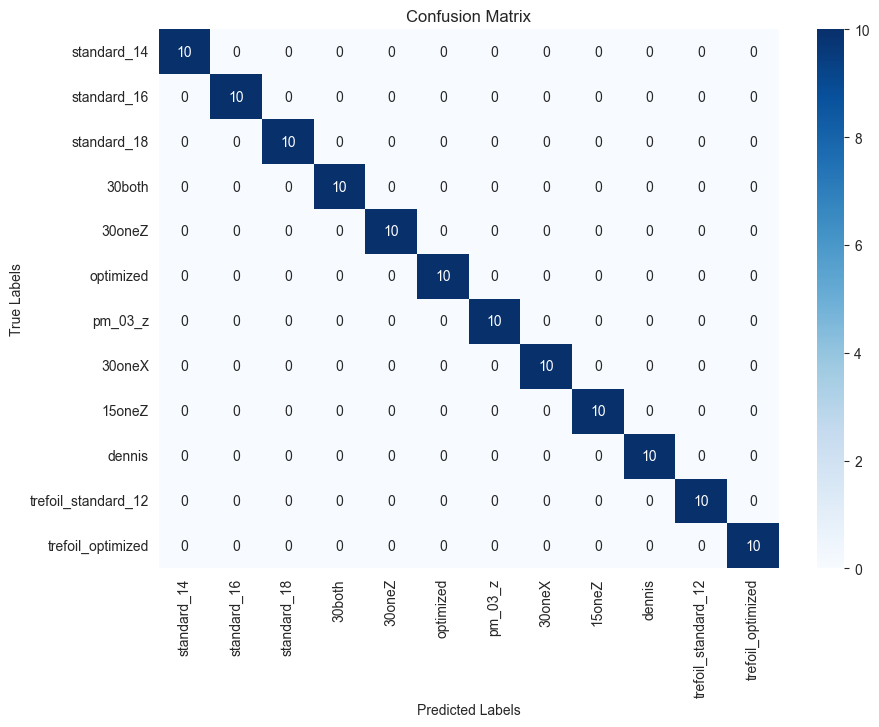

In [190]:
true_labels_np = true_classes.numpy() if isinstance(true_classes, torch.Tensor) else true_classes
predicted_labels_np = predicted_classes.numpy() if isinstance(predicted_classes, torch.Tensor) else predicted_classes

# Generate the confusion matrix
cm = confusion_matrix(true_labels_np, predicted_labels_np)

# Define class names for the x and y ticks (knots)
knots = knots  # Assuming 12 classes, adjust as needed

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [191]:
# Initialize an empty list to store predicted classes
predicted_classes_dots = []

# Loop through each sample in the main dataset
for i, x in enumerate(X_torch_dots):
    # Reshape x if needed, here keeping the [1, 32, 32, 32] shape
    x = x.view(1, 32, 32, 32)

    # Calculate the MSE with each basis class sample
    mse_values = torch.mean((X_torch_dots_b - x) ** 2, dim=(1, 2, 3, 4))  # MSE over all dimensions except class

    # Find the index of the minimum MSE value
    min_mse_index = torch.argmin(mse_values)

    # The predicted class is the index of the minimum MSE
    predicted_class = y_dots_b[min_mse_index].nonzero().item()

    # Store the predicted class
    predicted_classes_dots.append(predicted_class)

# Convert the list to a tensor for easier comparison with true labels if needed
predicted_classes_dots = torch.tensor(predicted_classes_dots)

# Optionally, calculate accuracy by comparing predicted classes with true labels
true_classes_dots = torch.argmax(y_dots, dim=1)
accuracy = (predicted_classes_dots == true_classes_dots).float().mean()

print("Predicted classes:", predicted_classes_dots)
print("Accuracy:", accuracy.item())

Predicted classes: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
Accuracy: 1.0


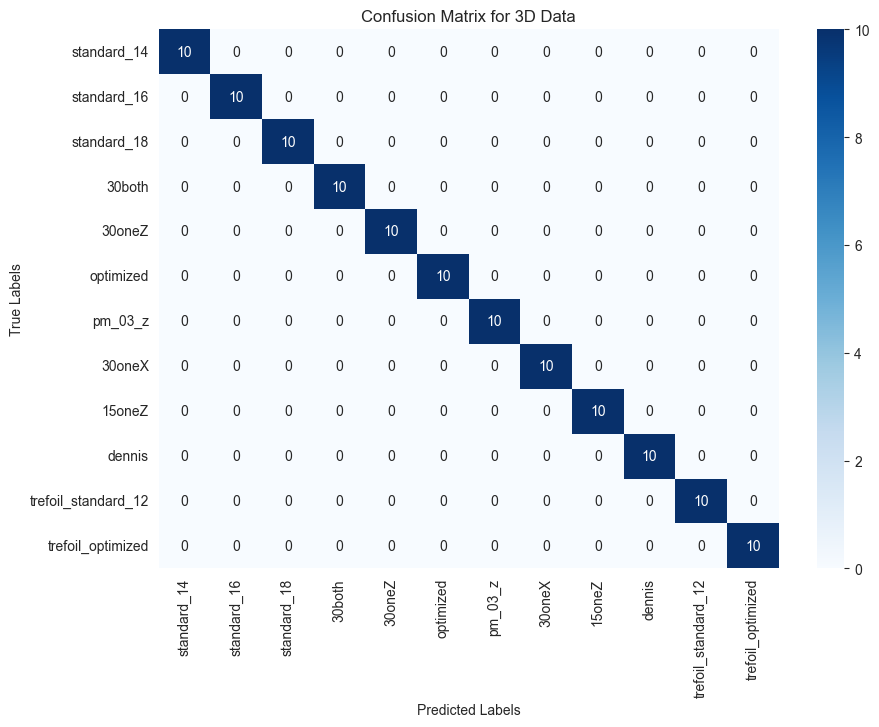

In [192]:
# Convert to numpy arrays if they are PyTorch tensors
true_labels_np_dots = true_classes_dots.numpy() if isinstance(true_classes_dots, torch.Tensor) else true_classes_dots
predicted_labels_np_dots = predicted_classes_dots.numpy() if isinstance(predicted_classes_dots, torch.Tensor) else predicted_classes_dots

# Generate the confusion matrix
cm_dots = confusion_matrix(true_labels_np_dots, predicted_labels_np_dots)

# Define class names for the x and y ticks
knots_dots = knots  # Adjust based on the number of classes if different

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dots, annot=True, fmt="d", xticklabels=knots_dots, yticklabels=knots_dots, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for 3D Data')
plt.show()

In [193]:
# L_prop = 270  # propagation distance
# knot_length = 212.58897655870774 / 2 * 1.4
# lmbda = 532e-9  # wavelength
# center_plane = 1
# xy_lim_2D_origin = (-30.0e-3, 30.0e-3)
# scale = 1
# res_xy_2D_origin = int(scale * 300)
# x_2D_origin = np.linspace(*xy_lim_2D_origin, res_xy_2D_origin)
# y_2D_origin = np.linspace(*xy_lim_2D_origin, res_xy_2D_origin)
# mesh_2D_original = np.meshgrid(x_2D_origin, y_2D_origin, indexing='ij')
# k0 = 2 * np.pi / lmbda  # wave number
# z0 = knot_length * (1 - center_plane) + L_prop  # the source position
# width0 = 6.0e-3 / np.sqrt(2)  # beam width

In [194]:
# folder1 = folders[1]
# for knot in knots:
# 	print(knot)
# 	with open(f'{folder1}/{knot}.pkl', 'rb') as file:
# 			values = pickle.load(file)
# 	# if os.path.exists(f'../{folder}/{knot}.pkl'):
# 	# 	with open(f'../{folder}/{knot}.pkl', 'rb') as file:
# 	# 		values = pickle.load(file)
# 	# else:
# 	# 	values = knot_types[knot](mesh_3D_knot, braid_func=braid, plot=True)
# 	# 	with open(f'../{folder}/{knot}.pkl', 'wb') as file:
# 	# 		pickle.dump(values, file)
# 	# printing values
# 	if 1:
# 		values_print = np.real(values['weight']) / np.sqrt(np.sum(np.real(values['weight']) ** 2)) * 10
# 		values_print_formatted = [f'{val:.2f}' for val in values_print]
# 		print(f'vales l: {values["l"]}, p: {values["p"]}, weights: {values_print_formatted}')
# 	# print(np.square(np.abs(values['weight'])).sum())
# 	# continue
# 	# building the knot from the coefficients
# 	field_before_prop = field_knot_from_weights(
# 		values, mesh_2D_original, width0, k0=k0, x0=0, y0=0, z0=z0
# 	)
# 	moments = {'p': (0, 6), 'l': (-6, 6)}
# 	# mesh_2D =
# 	spectrum = cbs.LG_spectrum(
# 		field_before_prop, **moments, mesh=mesh_2D_original, plot=False, width=width0, k0=k0,
# 		functions=LG_simple, x0=0, y0=0, z0=z0
# 	)
# 	# print(np.max(np.abs(spectrum)))
# 	print(np.square(np.abs(spectrum)).sum())
# 	plt.imshow(np.abs(spectrum))
# 	plt.show()